# Ensemble for PTB Dataset
The goal of this notebook is to evaluate the potential benefits of an ensemble model for the PTB Diagnostic ECG Database: https://www.physionet.org/content/ptbdb/1.0.0/  

The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat



In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from keras.engine.saving import load_model
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve, \
roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Read the data and normalize

In [2]:
timepoints_per_sample = 187
data_path_normal =  "../input/ptbdb_normal.csv"
data_path_abnormal = "../input/ptbdb_abnormal.csv"
df_1 = pd.read_csv(data_path_normal, header=None)
df_2 = pd.read_csv(data_path_abnormal, header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

X_bl = np.array(df_train[list(range(187))].values)[..., np.newaxis]
X_test_bl = np.array(df_test[list(range(187))].values)[..., np.newaxis]

# normalize without taking the zero-padding at the end into account:
for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])

for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

## Naive Model Averaging

The following are the naive approaches to aggregate the results from several classification models.

In [3]:
MODEL_NUM = 4

resnet_ptb = load_model("../saved_trained_models/paper_resnet_ptb.h5")
own_cnn_ptb = load_model("../saved_trained_models/own_cnn_ptb.h5")
own_lstm_ptb = load_model("../saved_trained_models/own_lstm_ptb.h5")
own_bidir_lstm_ptb = load_model('../saved_trained_models/own_bidirect_bidir_lstm_ptbdb.h5')

model_ensemble = [resnet_ptb, own_cnn_ptb, own_lstm_ptb, own_bidir_lstm_ptb]

1. Average the outputs of the sigmoid layer and classify based on them.

In [4]:
ensemble_output_1 = (resnet_ptb.predict(X_test) + own_cnn_ptb.predict(X_test) + 
                     own_lstm_ptb.predict(X_test) + own_bidir_lstm_ptb.predict(X_test))/MODEL_NUM

prediction_1 = (ensemble_output_1>0.5).astype(np.int8)

In [5]:
print("Accuracy: {0:.3f}".format(accuracy_score(Y_test, prediction_1)))
print("F1 score: {0:.3f}".format(f1_score(Y_test, prediction_1)))

Accuracy: 0.987
F1 score: 0.991


2. Perform majority voting.

In [6]:
# voting
votes = [[],[],[],[]]
votes[0] = ((resnet_ptb.predict(X_test))>0.5).astype(np.int8).flatten()
votes[1] = ((own_cnn_ptb.predict(X_test))>0.5).astype(np.int8).flatten()
votes[2] = ((own_lstm_ptb.predict(X_test))>0.5).astype(np.int8).flatten()
votes[3] = ((own_bidir_lstm_ptb.predict(X_test))>0.5).astype(np.int8).flatten()

ensemble_output_2 = votes[0] + votes[1] + votes[2] + votes[3]
ties_breaker = np.random.binomial(1, 0.5, ensemble_output_2.shape[0])
# in case output equals two (tie) we will randomly assing to class
ensemble_output_2 = ensemble_output_2 + ties_breaker

prediction_2 = (ensemble_output_2>(MODEL_NUM/2)).astype(np.int8)

In [7]:
print("Accuracy: {0:.3f}".format(accuracy_score(Y_test, prediction_2)))
print("F1 score: {0:.3f}".format(f1_score(Y_test, prediction_2)))

Accuracy: 0.972
F1 score: 0.981


## Logistic Regression 

We now perform logistic regression on the ensemble outputs.

In [8]:
# prepare training and test set for logisitc regression
ens_input = {'resnet': list( resnet_ptb.predict(X).flatten()),
             'cnn': list( own_cnn_ptb.predict(X).flatten()),
             'lstm': list( own_lstm_ptb.predict(X).flatten()),
             'bidir': list( own_bidir_lstm_ptb.predict(X).flatten())}

ens_df = pd.DataFrame(data=ens_input)

ens_input_test = {'resnet': list( resnet_ptb.predict(X_test).flatten()),
                  'cnn': list( own_cnn_ptb.predict(X_test).flatten()),
                  'lstm': list( own_lstm_ptb.predict(X_test).flatten()),
                  'bidir': list( own_bidir_lstm_ptb.predict(X_test).flatten())}

ens_test_df = pd.DataFrame(data=ens_input_test)

In [9]:
clf = LogisticRegression(random_state=0).fit(ens_df, Y)

In [10]:
ensemble_output_3 = clf.predict_proba(ens_test_df)[:,1]
prediction_3 = clf.predict(ens_test_df)
print("Accuracy: {0:.4f}".format(accuracy_score(Y_test, prediction_3)))
print("F1 score: {0:.4f}".format(f1_score(Y_test, prediction_3)))

Accuracy: 0.9938
F1 score: 0.9957


The logistic regression approach gives much better results than naive approaches. It also performs better than the baseline 0.993 vs 0.985.

## **Results**

Compare the results of all classification models using ROC curve. Resulting plots are included in the final report.

In [11]:
def prepare_roc_input(keras_model, X_test, Y_test, plot_roc=True):
    
    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
    auc_keras = roc_auc_score(Y_test, y_pred_keras)

    return fpr_keras, tpr_keras, auc_keras

In [12]:
# Add transfer learning models to compare all our models for PTB in 1 plot
model_transfer_1 = load_model("../saved_trained_models/own_lstm_ptb_transfer_frozen.h5")
model_transfer_2 = load_model("../saved_trained_models/own_lstm_ptb_transfer_trainable.h5")
model_transfer_3 = load_model("../saved_trained_models/own_lstm_ptb_transfer_frozen_then_trainable.h5")

In [13]:
fpr_resnet, tpr_resnet, auc_resnet = prepare_roc_input(resnet_ptb, X_test, Y_test, plot_roc=False)
fpr_cnn, tpr_cnn, auc_cnn = prepare_roc_input(own_cnn_ptb, X_test, Y_test, plot_roc=False)
fpr_lstm, tpr_lstm, auc_lstm = prepare_roc_input(own_lstm_ptb, X_test, Y_test, plot_roc=False)
fpr_bidir, tpr_bidir, auc_bidir = prepare_roc_input(own_bidir_lstm_ptb, X_test, Y_test, plot_roc=False)

#TRANSFER LEARNING
fpr_trans1, tpr_trans1, auc_trans1 = prepare_roc_input(model_transfer_1, X_test, Y_test, plot_roc=False)
fpr_trans2, tpr_trans2, auc_trans2 = prepare_roc_input(model_transfer_2, X_test, Y_test, plot_roc=False)
fpr_trans3, tpr_trans3, auc_trans3 = prepare_roc_input(model_transfer_3, X_test, Y_test, plot_roc=False)

#BASELINE MODEL
baseline_model = load_model("../saved_trained_models/baseline_cnn_ptb.h5")
fpr_bl, tpr_bl, auc_bl = prepare_roc_input(baseline_model, X_test=X_test_bl, Y_test=Y_test, plot_roc=False)

#ENSEMBLE MODELS
fp_ens, tp_ens, _ = roc_curve(Y_test, ensemble_output_3)
auc_ens = roc_auc_score(Y_test, ensemble_output_3)



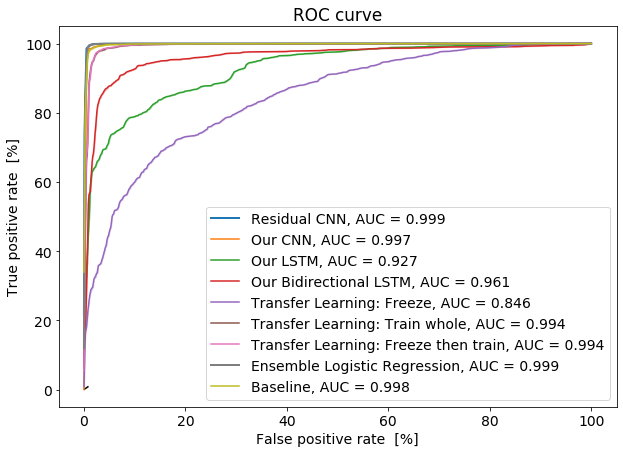

In [14]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')


sns.lineplot(100*fpr_resnet, 100*tpr_resnet, label='Residual CNN, AUC = {:.3f}'.format(auc_resnet), linewidth=2)
sns.lineplot(100*fpr_cnn, 100*tpr_cnn, label='Our CNN, AUC = {:.3f}'.format(auc_cnn))
sns.lineplot(100*fpr_lstm, 100*tpr_lstm, label='Our LSTM, AUC = {:.3f}'.format(auc_lstm))
sns.lineplot(100*fpr_bidir, 100*tpr_bidir, label='Our Bidirectional LSTM, AUC = {:.3f}'.format(auc_bidir))

# Transfer
sns.lineplot(100*fpr_trans1, 100*tpr_trans1, label='Transfer Learning: Freeze, AUC = {:.3f}'\
             .format(auc_trans1))
sns.lineplot(100*fpr_trans2, 100*tpr_trans2, label='Transfer Learning: Train whole, AUC = {:.3f}'\
             .format(auc_trans2))
sns.lineplot(100*fpr_trans3, 100*tpr_trans3, label='Transfer Learning: Freeze then train, AUC = {:.3f}'\
             .format(auc_trans3))

#Ensemble
sns.lineplot(100*fp_ens, 100*tp_ens, label='Ensemble Logistic Regression, AUC = {:.3f}'\
             .format(auc_ens), linewidth=2)

#Baseline
sns.lineplot(100*fpr_bl, 100*tpr_bl, label='Baseline, AUC = {:.3f}'.format(auc_bl))


plt.xlabel('False positive rate  [%]')
plt.ylabel('True positive rate  [%]')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("roc_all_ptb.pdf")
plt.show()

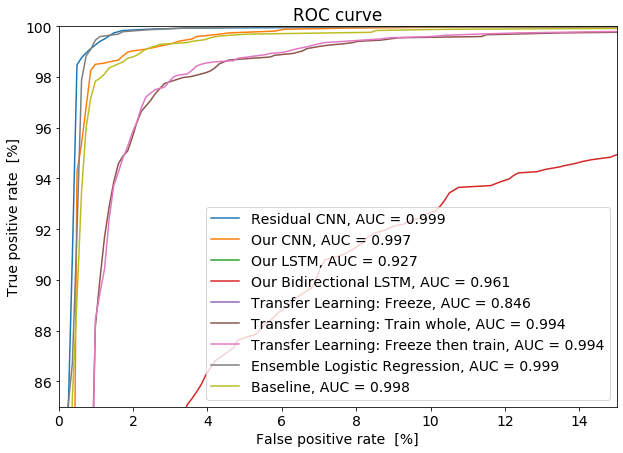

In [19]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(1, figsize=(10, 7))
plt.xlim(0, 15)
plt.ylim(85, 100)
plt.plot([0, 1], [0, 1], 'k--')


sns.lineplot(100*fpr_resnet, 100*tpr_resnet, label='Residual CNN, AUC = {:.3f}'.format(auc_resnet), ci=None)
sns.lineplot(100*fpr_cnn, 100*tpr_cnn, label='Our CNN, AUC = {:.3f}'.format(auc_cnn),ci=None)
sns.lineplot(100*fpr_lstm, 100*tpr_lstm, label='Our LSTM, AUC = {:.3f}'.format(auc_lstm),ci=None)
sns.lineplot(100*fpr_bidir, 100*tpr_bidir, label='Our Bidirectional LSTM, AUC = {:.3f}'.format(auc_bidir),ci=None)

# Transfer
sns.lineplot(100*fpr_trans1, 100*tpr_trans1, label='Transfer Learning: Freeze, AUC = {:.3f}'\
             .format(auc_trans1),ci=None)
sns.lineplot(100*fpr_trans2, 100*tpr_trans2, label='Transfer Learning: Train whole, AUC = {:.3f}'\
             .format(auc_trans2),ci=None)
sns.lineplot(100*fpr_trans3, 100*tpr_trans3, label='Transfer Learning: Freeze then train, AUC = {:.3f}'\
             .format(auc_trans3),ci=None)

#Ensemble
sns.lineplot(100*fp_ens, 100*tp_ens, label='Ensemble Logistic Regression, AUC = {:.3f}'\
             .format(auc_ens),ci=None)

#Baseline
sns.lineplot(100*fpr_bl, 100*tpr_bl, label='Baseline, AUC = {:.3f}'.format(auc_bl),ci=None)


plt.xlabel('False positive rate  [%]')
plt.ylabel('True positive rate  [%]')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("roc_all_ptb_zoom.pdf")
plt.show()